In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='./brain_tumor_dataset', transform=transform)

In [3]:
len(dataset)

253

In [4]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=True)

In [6]:
num_classes = dataset.classes

In [7]:
data_iter = iter(train_dataset)
images, labels = next(data_iter)

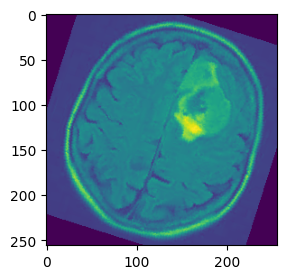

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.imshow(images[0])
plt.show()

In [9]:
class TumorClassifer(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding='same'), # (32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # (32, 128, 128)
            nn.Conv2d(32, 64, kernel_size=(3,3)), # (64, 126, 126)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # (64, 63, 63)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 63 * 63, 600),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 2)
        )
    def forward(self, x):
        x = self.network(x)
        x = self.fc_layers(x)
        return x

In [10]:
x = torch.randn(1, 3, 256, 256)
model = TumorClassifer()
y = model.network(x)
print(y.shape)


torch.Size([1, 64, 63, 63])


In [11]:
model = TumorClassifer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, loss: {running_loss / len(train_dataset)}")


Epoch 1/10, loss: 0.12384675104151327
Epoch 2/10, loss: 0.021556176521159983
Epoch 3/10, loss: 0.02075515758423578
Epoch 4/10, loss: 0.01890360299872343
Epoch 5/10, loss: 0.017042391987704728
Epoch 6/10, loss: 0.015349065342908183
Epoch 7/10, loss: 0.014458259892842126
Epoch 8/10, loss: 0.011827638540318403
Epoch 9/10, loss: 0.010575402429494908
Epoch 10/10, loss: 0.009535353571649582


In [13]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy : {100 * correct / total}")

Accuracy : 81.25


In [14]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

from PIL import Image

image = Image.open("no/33 no.jpg").convert("RGB")
image = test_transform(image)
image = image.unsqueeze(0)

with torch.no_grad():
    output = model(image)
    _,predicted = torch.max(output.data, 1)
    print("predictd : ", predicted)

predictd :  tensor([0])


In [15]:
print(dataset.classes)

['no', 'yes']


In [118]:
torch.save(model.state_dict(), 'saved_model.pth')

In [16]:
import torch
# from model import TumorClassifer   # or wherever your model class is

# Load trained model
# model = TumorClassifer()
model.load_state_dict(torch.load("saved_model.pth", map_location="cpu"))
model.eval()

# Dummy input MUST match training input shape
example_input = torch.randn(1, 3, 256, 256)

# Convert to TorchScript
scripted_model = torch.jit.trace(model, example_input)

# Save
scripted_model.save("brain_tumor_model.pt")

print("Model saved as brain_tumor_model.pt")


Model saved as brain_tumor_model.pt
